<a href="https://colab.research.google.com/github/enesdemirag/mapGAN/blob/master/mapGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Dependencies**

In [0]:
import os 
import time
import numpy as np
from PIL import Image
import tensorflow as tf
from termcolor import cprint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import UpSampling2D, Conv2D

%matplotlib inline

**Models**

In [0]:
class GAN(object):
    def __init__(self, resolution=64, channel=3):
        self.rows = resolution
        self.cols = resolution
        self.channel = channel
        self.D = None
        self.G = None
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = Adam(1.5e-4, 0.5)
        self.discriminator_optimizer = Adam(1.5e-4, 0.5)

    def discriminator(self, img_shape):
        self.D = Sequential()

        self.D.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        self.D.add(LeakyReLU(alpha=0.2))

        self.D.add(Dropout(0.25))
        self.D.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        self.D.add(ZeroPadding2D(padding=((0,1), (0,1))))
        self.D.add(BatchNormalization(momentum=0.8))
        self.D.add(LeakyReLU(alpha=0.2))

        self.D.add(Dropout(0.25))
        self.D.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        self.D.add(BatchNormalization(momentum=0.8))
        self.D.add(LeakyReLU(alpha=0.2))

        self.D.add(Dropout(0.25))
        self.D.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        self.D.add(BatchNormalization(momentum=0.8))
        self.D.add(LeakyReLU(alpha=0.2))

        self.D.add(Dropout(0.25))
        self.D.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        self.D.add(BatchNormalization(momentum=0.8))
        self.D.add(LeakyReLU(alpha=0.2))

        self.D.add(Dropout(0.25))
        self.D.add(Flatten())
        self.D.add(Dense(1, activation='sigmoid'))

        return self.D

    def generator(self, seed_size, resolution, channels):
        self.G = Sequential()

        self.G.add(Dense(4 * 4 * 256, activation="relu", input_dim=seed_size))
        self.G.add(Reshape((4, 4, 256)))

        self.G.add(UpSampling2D())
        self.G.add(Conv2D(256, kernel_size=3, padding="same"))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation("relu"))

        self.G.add(UpSampling2D())
        self.G.add(Conv2D(256, kernel_size=3, padding="same"))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation("relu"))
   
        self.G.add(UpSampling2D())
        self.G.add(Conv2D(128, kernel_size=3, padding="same"))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation("relu"))

        self.G.add(UpSampling2D(size=(int(resolution / 32), int(resolution / 32))))
        self.G.add(Conv2D(128, kernel_size=3, padding="same"))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation("relu"))

        self.G.add(Conv2D(channels, kernel_size=3, padding="same"))
        self.G.add(Activation("tanh"))

        return self.G

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

**Dataset**

In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks/mapGAN/")
binary = os.path.join("dataset.npy")
data = np.load(binary)

**Configuration**


In [0]:
resolution = 64
channels = 3
epochs = 50
batch_size = 32
buffer_size = 3000
seed_size = 100
image_shape = (resolution, resolution, channels)
preview_rows = 3
preview_cols = 3
preview_margin = 10

cprint("--- Configurations ---", "blue", attrs=['bold'])
cprint("Resolution: %8dpx" %resolution, "green")
cprint("Epochs: %14d" %epochs, "green")
cprint("Batch Size: %10d" %batch_size, "green")
cprint("Buffer Size: %9d" %buffer_size, "green")
cprint("Seed Size: %11d\n" %seed_size, "green")

**GAN**

In [0]:
gan = GAN(resolution=resolution, channel=channels)
g = gan.generator(seed_size, resolution, channels)
d = gan.discriminator(image_shape)
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size).batch(batch_size)

**Before Training**

In [0]:
noise = tf.random.normal([1, seed_size])
generated_image = g(noise, training=False)
prediction = d(generated_image)

cprint("Generated image is %d%% real." %(prediction * 100), "cyan")

plt.imshow(generated_image[0, :, :, 0])

**Functions**

In [0]:
def nice_time(sec):
    h = int(sec / (60 * 60))
    m = int((sec % (60 * 60)) / 60)
    s = sec % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

@tf.function
def train_step(images):
    seed = tf.random.normal([batch_size, seed_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = g(seed, training=True)
        real_output = d(images, training=True)
        fake_output = d(generated_images, training=True)
        
        gen_loss = gan.generator_loss(fake_output)
        disc_loss = gan.discriminator_loss(real_output, fake_output)
    
        gradients_of_generator = gen_tape.gradient(gen_loss, g.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, d.trainable_variables)

        gan.generator_optimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
        gan.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (preview_rows * preview_cols, seed_size))
    train_start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        gen_loss_list = []
        disc_loss_list = []
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time() - epoch_start
        cprint("Epoch: %d/%d, Generator Loss: %f, Discriminator Loss: %f, Elapsed Time: %s" %((epoch + 1), epochs, g_loss, d_loss, nice_time(epoch_elapsed)), "blue", attrs=['bold'])
        # save_images(epoch, fixed_seed)

    train_elapsed = time.time() - train_start
    cprint("Training Time: %s" %nice_time(train_elapsed), "yellow", attrs=['bold'])

def save_images(index, noise):
    image_array = np.full((preview_margin * 2 + (preview_rows * (resolution + preview_margin)), preview_margin * 2 + (preview_cols * (resolution + preview_margin)), 3), 255, dtype=np.uint8)
    generated_images = g.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(preview_rows):
        for col in range(preview_cols):
            r = row * (resolution + 16) + preview_margin
            c = col * (resolution + 16) + preview_margin
            image_array[r:r + resolution, c:c + resolution] = generated_images[image_count] * 255
            image_count += 1

    im = Image.fromarray(image_array)
    im.save("map-" + str(index + 1) + ".png")

**Train**

In [0]:
train(dataset, epochs)

**After Training**

In [0]:
noise = tf.random.normal([1, seed_size])
generated_image = g(noise, training=False)
prediction = d(generated_image)

cprint("Generated image is %d%% real." %(prediction * 100), "cyan")

plt.imshow(generated_image[0, :, :, 0])

**Save**

In [0]:
g.save("mapGAN.h5")
cprint("Generator model saved as 'mapGAN.h5'.", "blue", attrs=['bold'])

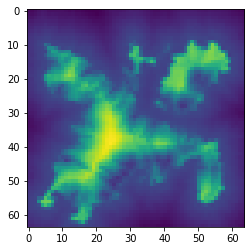

In [33]:
# Example input image from dataset